In [1]:
# System
import pathlib
import glob
import os, os.path, shutil
# Data Exploration
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import pandas as pd
import seaborn as sns
from PIL import Image
# Machine Learning
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
#Deep Learning
import tensorflow as tf
import keras
from keras.utils import plot_model ######
from keras import backend as K ##########
from keras import metrics
from keras.regularizers import l2,l1
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation
from keras.preprocessing.image import img_to_array, ImageDataGenerator, array_to_img, load_img
from keras.metrics import AUC
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
# Something unknown :)
import pydot
from dask import bag,  diagnostics
from mlxtend.plotting import plot_confusion_matrix

2023-11-29 03:05:12.523322: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-29 03:05:12.731512: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-29 03:05:12.731723: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-29 03:05:12.766039: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-29 03:05:12.852983: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-29 03:05:12.855791: I tensorflow/core/platform/cpu_feature_guard.cc:1

### Convolutional Neural Network

In [6]:
def create_charts(cnn, cnn_model):
    """
    plot1: train & validatoin loss curves
    plot2: train & validatoin accuracy curves
    Plot3: confusion matrix
    Plot4: train & validation ROC curve and AUC score
    Summary Statistics
    
    """
    
    ## Define train & validation loss
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    
    ## Define train & validation accuracy
    train_auc = cnn_model.history['accuracy']
    val_auc = cnn_model.history['val_accuracy']
    
    ## Define y_pred & y_true
    y_true = test_generator.classes
    Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))
    y_pred = (Y_pred > 0.5).T[0]
    y_pred_prob = Y_pred.T[0]
    
    ## PLOT ##
    fig = plt.figure(figsize=(13, 10))
    
    ## PLOT 1: TRAIN VS. VALIDATION LOSS 
    plt.subplot(2,2,1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    ## PLOT 2: TRAIN VS. VALIDATION Accuracy
    plt.subplot(2,2,2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label='training auc')
    plt.plot(val_auc, label='validation auc')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    
    ## PLOT 3: CONFUSION MATRIX
    plt.subplot(2,2,3)
    # Set up the labels for in the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
  
    names = ['True Positives', 'False Negatives', 'False Positives', 'True Negatives']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ticklabels = ['CORROSION', 'NOCORROSION']

      # Create confusion matrix as heatmap
    sns.set(font_scale = 1.4)
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels )
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix") #plt.title("Confusion Matrix\n", fontsize=10)
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14) 
    #plt.savefig('cm.png', transparent=True) 
    
    ## PLOT 4: ROC CURVE
    plt.subplot(2,2,4)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
    plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc*100))
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='best')
    #plt.savefig('roc.png', bbox_inches='tight', pad_inches=1)
    
    ## END PLOTS
    plt.tight_layout()
    
    ## Summary Statistics
    TP, FN, FP, TN = cm.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
    accuracy = (TP + TN) / np.sum(cm) # % positive out of all predicted positives
    precision = TP / (TP+FP) # % positive out of all predicted positives
    recall =  TP / (TP+FN) # % positive out of all supposed to be positives
    specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
    f1 = 2*precision*recall / (precision + recall)
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)

In [7]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

In [8]:
# Build data generator function

def make_data_generator(
    train_datagen, train_dir, 
    val_datagen, val_dir, 
    test_datagen, test_dir):
    
    datagen_lst = [train_datagen, val_datagen, test_datagen]
    directory_lst = [train_dir, val_dir, test_dir]
    generator_lst = []
    for generator, directory in zip(datagen_lst, directory_lst):
        if directory == train_dir:
            shuffle = True
        else:
            shuffle = False
        g = generator.flow_from_directory(directory = directory,
                                         target_size = (256,256),
                                         batch_size = 32,
                                         color_mode = 'rgb',
                                         class_mode = 'binary',
                                         shuffle = shuffle,
                                         seed = 42
                                         )
        generator_lst.append(g)
    
    return generator_lst

In [11]:
train_dir = 'split/train'
train_CORROSION_dir = 'split/train/CORROSION/'
train_NOCORROSION_dir = 'split/train/NOCORROSION/'

validation_dir = 'split/validation'
validation_CORROSION_dir = 'split/validation/CORROSION/'
validation_NOCORROSION_dir = 'split/validation/NOCORROSION/'

test_dir = 'split/test'
test_CORROSION_dir = 'split/test/CORROSION/'
test_NOCORROSION_dir = 'split/test/NOCORROSION/'

In [12]:
def num_files_in_direcotry(path):
    num = len([file for file in os.listdir(path) if file.endswith('.jpg')])
    return num

In [13]:
train_CORROSION_num = num_files_in_direcotry(train_CORROSION_dir)
train_NOCORROSION_num = num_files_in_direcotry(train_NOCORROSION_dir)
train_SUM_num = train_CORROSION_num + train_NOCORROSION_num

print("[Train] Number of CORROSION Images: ", train_CORROSION_num)
print("[Train] Number of NOCORROSION Images: ", train_NOCORROSION_num)
print("[Train] Number of TOTAL Images: ", train_SUM_num)

[Train] Number of CORROSION Images:  693
[Train] Number of NOCORROSION Images:  580
[Train] Number of TOTAL Images:  1273


In [14]:
# Load the images

train_datagen = ImageDataGenerator(rescale = 1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator,val_generator, test_generator = make_data_generator(
    train_datagen, train_dir,
    val_datagen, validation_dir,
    test_datagen, test_dir)

Found 1273 images belonging to 2 classes.


Found 364 images belonging to 2 classes.
Found 182 images belonging to 2 classes.


In [108]:
# CNN model
model = keras.Sequential([
            keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
            keras.layers.MaxPooling2D((2, 2)),

            keras.layers.Conv2D(64, (3, 3), activation='relu'),
            keras.layers.MaxPooling2D((2, 2)),

            keras.layers.Conv2D(128, (3, 3), activation='relu'),
            keras.layers.MaxPooling2D((2, 2)),

            keras.layers.Flatten(),

            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dense(1, activation='sigmoid')
        ])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_48 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_49 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_49 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_50 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_50 (MaxPooli  (None, 30, 30, 128)     

In [102]:
# Train the model

cnn_model = model.fit_generator(train_generator,
                              epochs = 30,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1)

/tmp/ipykernel_6019/119983786.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn_model = model.fit_generator(train_generator,


Epoch 1/30
40/40 [==============================] - 55s 1s/step - loss: 0.3823 - accuracy: 0.8335 - val_loss: 0.4682 - val_accuracy: 0.7912
Epoch 2/30
40/40 [==============================] - 56s 1s/step - loss: 0.3383 - accuracy: 0.8657 - val_loss: 0.5136 - val_accuracy: 0.7418
Epoch 3/30
40/40 [==============================] - 56s 1s/step - loss: 0.3221 - accuracy: 0.8837 - val_loss: 0.4293 - val_accuracy: 0.8159
Epoch 4/30
40/40 [==============================] - 56s 1s/step - loss: 0.2690 - accuracy: 0.9042 - val_loss: 0.4151 - val_accuracy: 0.8324
Epoch 5/30
40/40 [==============================] - 56s 1s/step - loss: 0.2432 - accuracy: 0.9144 - val_loss: 0.4286 - val_accuracy: 0.8269
Epoch 6/30
40/40 [==============================] - 56s 1s/step - loss: 0.2305 - accuracy: 0.9254 - val_loss: 0.4560 - val_accuracy: 0.7995
Epoch 7/30
40/40 [==============================] - 58s 1s/step - loss: 0.1929 - accuracy: 0.9395 - val_loss: 0.4079 - val_accuracy: 0.8352
Epoch 8/30
40/40 [==

/tmp/ipykernel_6019/2805508428.py:21: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))


[Summary Statistics]
Accuracy = 82.42% | Precision = 80.73% | Recall = 88.89% | Specificity = 74.70% | F1 Score = 84.62%


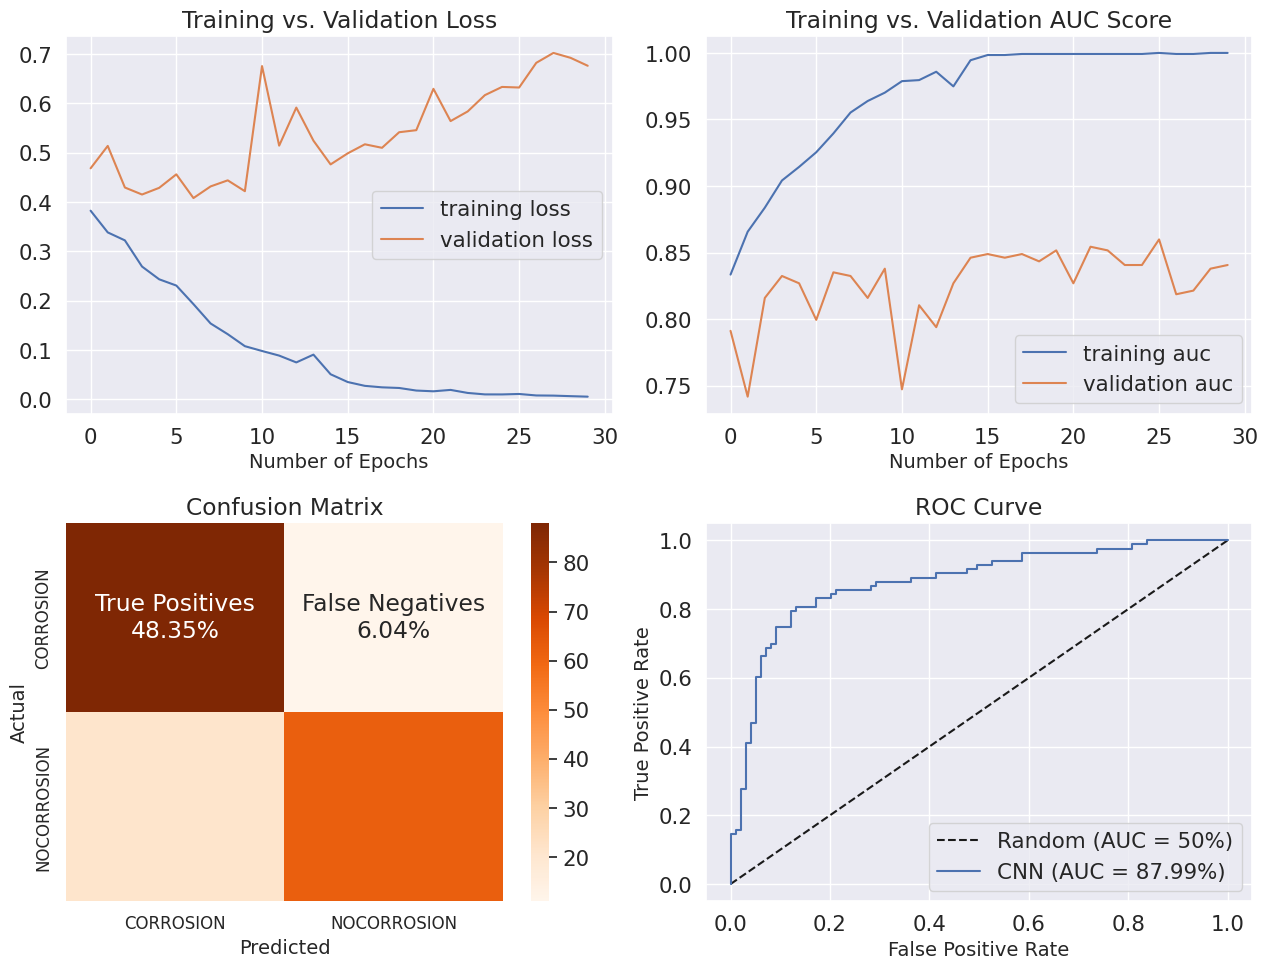

In [103]:
create_charts(model,cnn_model)
# model.save('/model/cnn1.h5')

In [107]:
# CNN model
model = keras.Sequential([
            keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
            keras.layers.MaxPooling2D((2, 2)),
            # keras.layers.Dropout(0.5))

            keras.layers.Conv2D(32, (3, 3), activation='relu'),
            keras.layers.MaxPooling2D((2, 2)),
            keras.layers.Dropout(0.3),

            keras.layers.Conv2D(64, (3, 3), activation='relu'),
            keras.layers.MaxPooling2D((2, 2)),
            keras.layers.Dropout(0.3),

            keras.layers.Conv2D(128, (3, 3), activation='relu'),
            keras.layers.MaxPooling2D((2, 2)),
            keras.layers.Dropout(0.3),

            keras.layers.Conv2D(128, (3, 3), activation='relu'),
            keras.layers.MaxPooling2D((2, 2)),
            keras.layers.Dropout(0.3),

            keras.layers.Conv2D(256, (3, 3), activation='relu'),
            keras.layers.MaxPooling2D((2, 2)),
            keras.layers.Dropout(0.3),

            keras.layers.Flatten(),
                    
            keras.layers.Dense(256, activation='relu'),
            keras.layers.Dense(1, activation='sigmoid')
        ])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_43 (Conv2D)          (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_43 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_19 (Dropout)        (None, 62, 62, 32)        0         
                                                                 
 conv2d_44 (Conv2D)          (None, 60, 60, 64)      

In [105]:
# Train the model

cnn_model = model.fit_generator(train_generator,
                              epochs = 30,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1)

/tmp/ipykernel_6019/119983786.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn_model = model.fit_generator(train_generator,


Epoch 1/30
40/40 [==============================] - 49s 1s/step - loss: 0.6962 - accuracy: 0.5420 - val_loss: 0.6914 - val_accuracy: 0.5440
Epoch 2/30
40/40 [==============================] - 47s 1s/step - loss: 0.6917 - accuracy: 0.5295 - val_loss: 0.6886 - val_accuracy: 0.5440
Epoch 3/30
40/40 [==============================] - 48s 1s/step - loss: 0.6707 - accuracy: 0.6198 - val_loss: 0.6648 - val_accuracy: 0.7005
Epoch 4/30
40/40 [==============================] - 47s 1s/step - loss: 0.6157 - accuracy: 0.6756 - val_loss: 0.6696 - val_accuracy: 0.5824
Epoch 5/30
40/40 [==============================] - 47s 1s/step - loss: 0.5816 - accuracy: 0.7046 - val_loss: 0.6073 - val_accuracy: 0.7225
Epoch 6/30
40/40 [==============================] - 48s 1s/step - loss: 0.5560 - accuracy: 0.7298 - val_loss: 0.5995 - val_accuracy: 0.7582
Epoch 7/30
40/40 [==============================] - 47s 1s/step - loss: 0.5268 - accuracy: 0.7510 - val_loss: 0.5708 - val_accuracy: 0.7610
Epoch 8/30
40/40 [==

/tmp/ipykernel_6019/2805508428.py:21: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))


[Summary Statistics]
Accuracy = 82.97% | Precision = 78.81% | Recall = 93.94% | Specificity = 69.88% | F1 Score = 85.71%


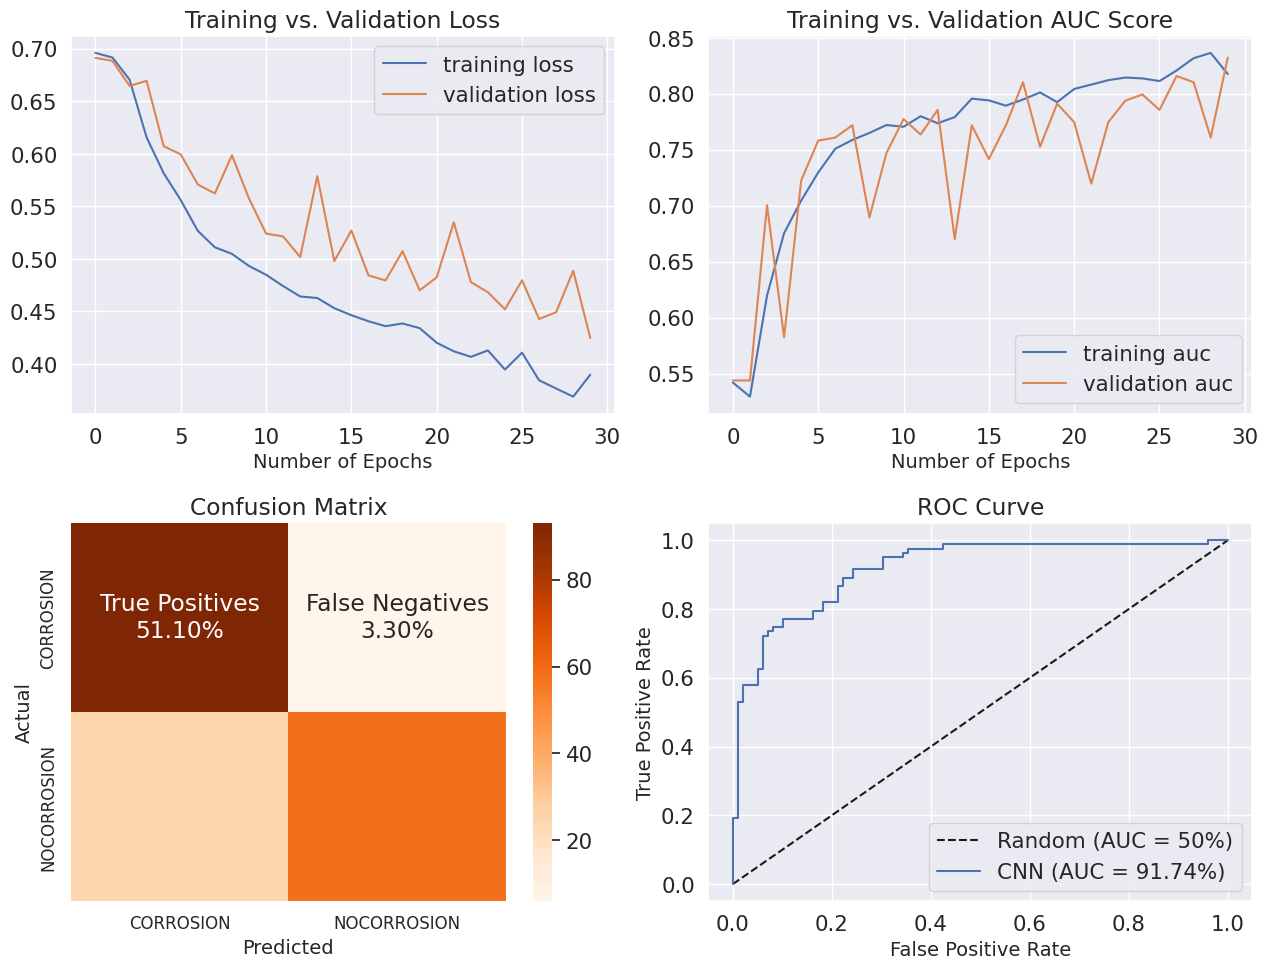

In [106]:
create_charts(model,cnn_model)
# model.save('/model/cnn2.h5')

In [109]:
model = keras.Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
            MaxPooling2D((2, 2)),
            # Dropout(0.5))

            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Dropout(0.3),

            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Dropout(0.3),

            Conv2D(256, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Dropout(0.3),


            Flatten(),
                    
            Dense(256, activation='relu'),
            Dense(1, activation='sigmoid')
        ])



# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_51 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_52 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_52 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_24 (Dropout)        (None, 62, 62, 64)        0         
                                                                 
 conv2d_53 (Conv2D)          (None, 60, 60, 128)     

In [110]:
# Train the model

cnn_model = model.fit_generator(train_generator,
                              epochs = 30,
                              steps_per_epoch = len(train_generator),
                              validation_datasssss = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1)

/tmp/ipykernel_6019/119983786.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn_model = model.fit_generator(train_generator,


Epoch 1/30
40/40 [==============================] - 72s 2s/step - loss: 0.7108 - accuracy: 0.5271 - val_loss: 0.6839 - val_accuracy: 0.5934
Epoch 2/30
40/40 [==============================] - 70s 2s/step - loss: 0.6407 - accuracy: 0.6379 - val_loss: 0.6564 - val_accuracy: 0.6264
Epoch 3/30
40/40 [==============================] - 70s 2s/step - loss: 0.5893 - accuracy: 0.6984 - val_loss: 0.6097 - val_accuracy: 0.7308
Epoch 4/30
40/40 [==============================] - 69s 2s/step - loss: 0.5490 - accuracy: 0.7510 - val_loss: 0.5772 - val_accuracy: 0.7418
Epoch 5/30
40/40 [==============================] - 68s 2s/step - loss: 0.5276 - accuracy: 0.7455 - val_loss: 0.5612 - val_accuracy: 0.7527
Epoch 6/30
40/40 [==============================] - 68s 2s/step - loss: 0.4970 - accuracy: 0.7510 - val_loss: 0.5386 - val_accuracy: 0.7665
Epoch 7/30
40/40 [==============================] - 66s 2s/step - loss: 0.5365 - accuracy: 0.7518 - val_loss: 0.5388 - val_accuracy: 0.7637
Epoch 8/30
40/40 [==

/tmp/ipykernel_6019/2805508428.py:21: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))


[Summary Statistics]
Accuracy = 80.77% | Precision = 80.19% | Recall = 85.86% | Specificity = 74.70% | F1 Score = 82.93%


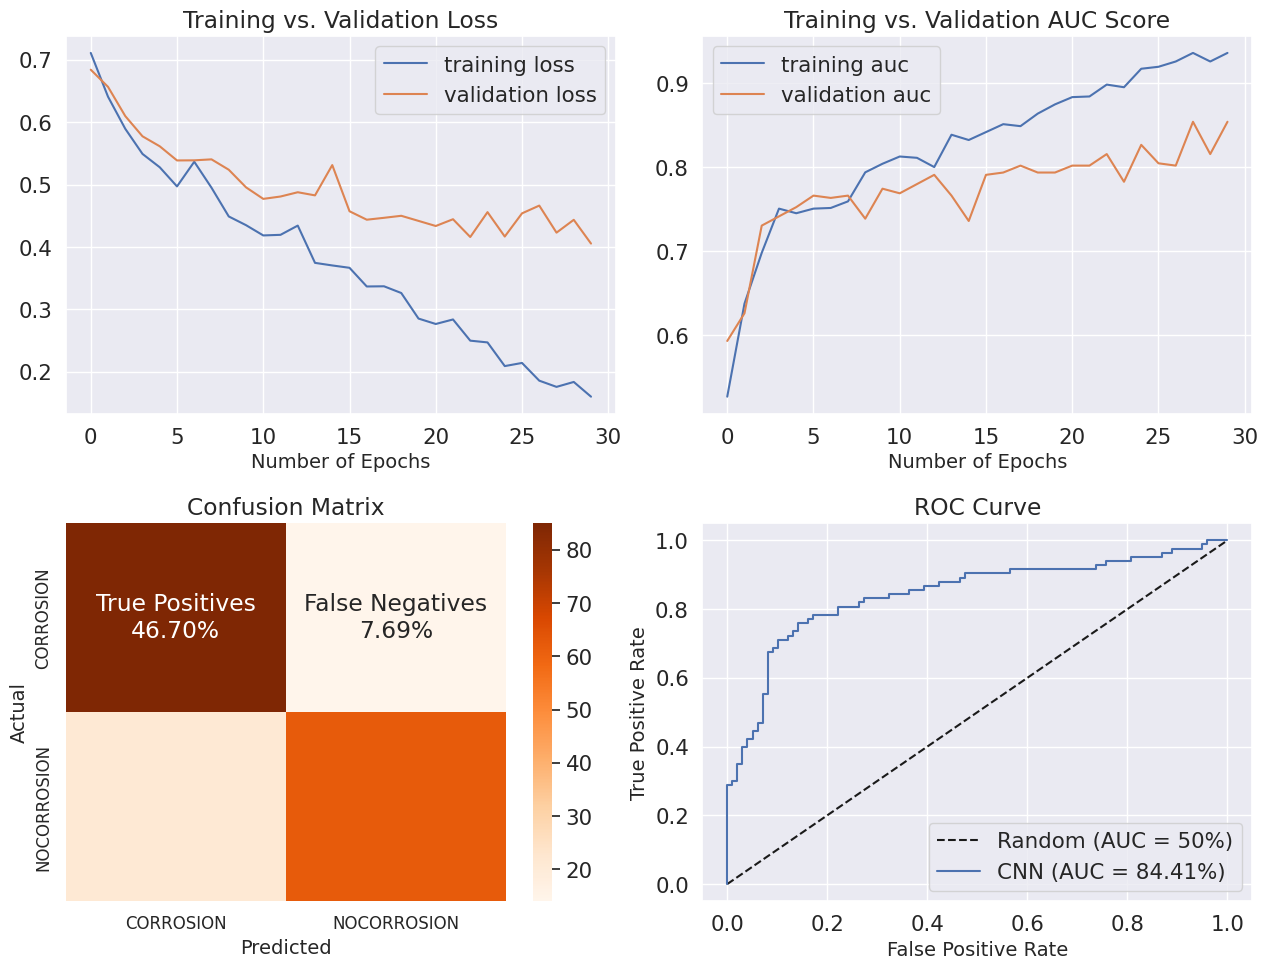

In [112]:
create_charts(model,cnn_model)
# model.save('/model/cnn3.h5')

In [113]:
model.save('cnn_model3.h5')

/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
# CNN model
model = keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    # Dropout(0.5)

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
            
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid'),
])


# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_4 (Flatten)         (None, 246016)            0         
                                                                 
 dense_8 (Dense)             (None, 64)               

In [24]:
# Train the model

cnn_model = model.fit_generator(train_generator,
                              epochs = 30,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1)

/tmp/ipykernel_4664/119983786.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn_model = model.fit_generator(train_generator,


Epoch 1/30
40/40 [==============================] - 53s 1s/step - loss: 0.7145 - accuracy: 0.5538 - val_loss: 0.6709 - val_accuracy: 0.5577
Epoch 2/30
40/40 [==============================] - 50s 1s/step - loss: 0.6148 - accuracy: 0.6528 - val_loss: 0.6284 - val_accuracy: 0.6676
Epoch 3/30
40/40 [==============================] - 51s 1s/step - loss: 0.5481 - accuracy: 0.7612 - val_loss: 0.5663 - val_accuracy: 0.7363
Epoch 4/30
40/40 [==============================] - 50s 1s/step - loss: 0.5095 - accuracy: 0.7683 - val_loss: 0.5500 - val_accuracy: 0.7088
Epoch 5/30
40/40 [==============================] - 51s 1s/step - loss: 0.4686 - accuracy: 0.7903 - val_loss: 0.5117 - val_accuracy: 0.7610
Epoch 6/30
40/40 [==============================] - 52s 1s/step - loss: 0.4359 - accuracy: 0.8075 - val_loss: 0.5174 - val_accuracy: 0.7527
Epoch 7/30
40/40 [==============================] - 50s 1s/step - loss: 0.4550 - accuracy: 0.7887 - val_loss: 0.5060 - val_accuracy: 0.7665
Epoch 8/30
40/40 [==

In [25]:
model.save('cnn4.h5')

/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


/tmp/ipykernel_4664/2805508428.py:21: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))


[Summary Statistics]
Accuracy = 81.87% | Precision = 79.46% | Recall = 89.90% | Specificity = 72.29% | F1 Score = 84.36%


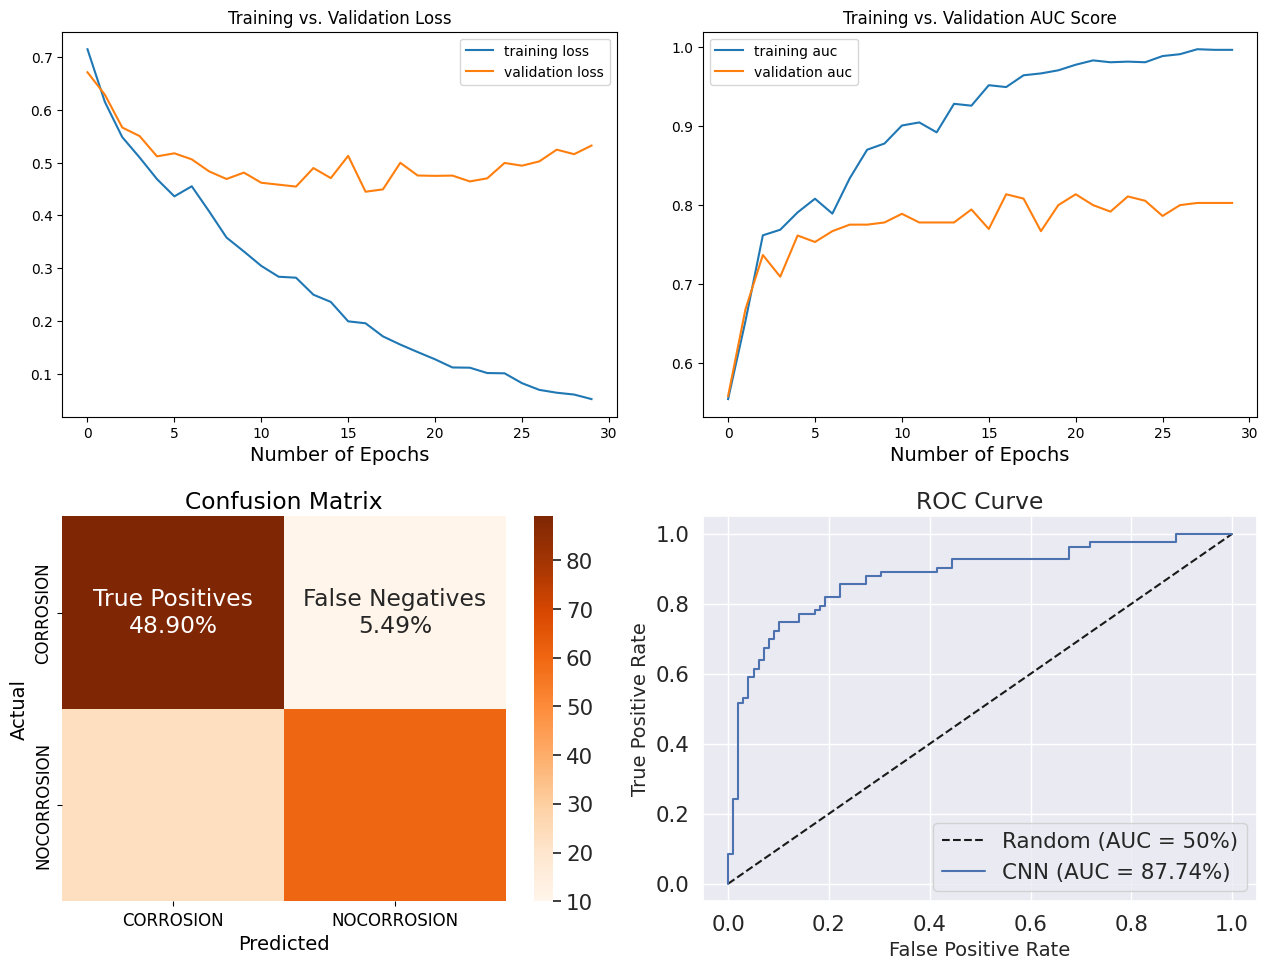

In [26]:
create_charts(model,cnn_model)
# model.save('/model/cnn3.h5')

In [29]:
model = Sequential([

    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    # Dropout(0.5)

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),


    Flatten(),
            
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])


# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 62, 62, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 60, 60, 128)      

In [30]:
# Train the model

cnn_model = model.fit_generator(train_generator,
                              epochs = 30,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1)

/tmp/ipykernel_4664/119983786.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn_model = model.fit_generator(train_generator,


Epoch 1/30
40/40 [==============================] - 64s 2s/step - loss: 0.6935 - accuracy: 0.5310 - val_loss: 0.6878 - val_accuracy: 0.5467
Epoch 2/30
40/40 [==============================] - 61s 2s/step - loss: 0.6704 - accuracy: 0.5703 - val_loss: 0.6596 - val_accuracy: 0.6703
Epoch 3/30
40/40 [==============================] - 63s 2s/step - loss: 0.6145 - accuracy: 0.6921 - val_loss: 0.6368 - val_accuracy: 0.7088
Epoch 4/30
40/40 [==============================] - 64s 2s/step - loss: 0.5613 - accuracy: 0.7392 - val_loss: 0.5868 - val_accuracy: 0.7418
Epoch 5/30
40/40 [==============================] - 63s 2s/step - loss: 0.5508 - accuracy: 0.7313 - val_loss: 0.5800 - val_accuracy: 0.7473
Epoch 6/30
40/40 [==============================] - 64s 2s/step - loss: 0.5164 - accuracy: 0.7565 - val_loss: 0.5578 - val_accuracy: 0.7473
Epoch 7/30
40/40 [==============================] - 64s 2s/step - loss: 0.5088 - accuracy: 0.7604 - val_loss: 0.5372 - val_accuracy: 0.7637
Epoch 8/30
40/40 [==

/tmp/ipykernel_4664/2805508428.py:21: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))


[Summary Statistics]
Accuracy = 76.37% | Precision = 70.90% | Recall = 95.96% | Specificity = 53.01% | F1 Score = 81.55%


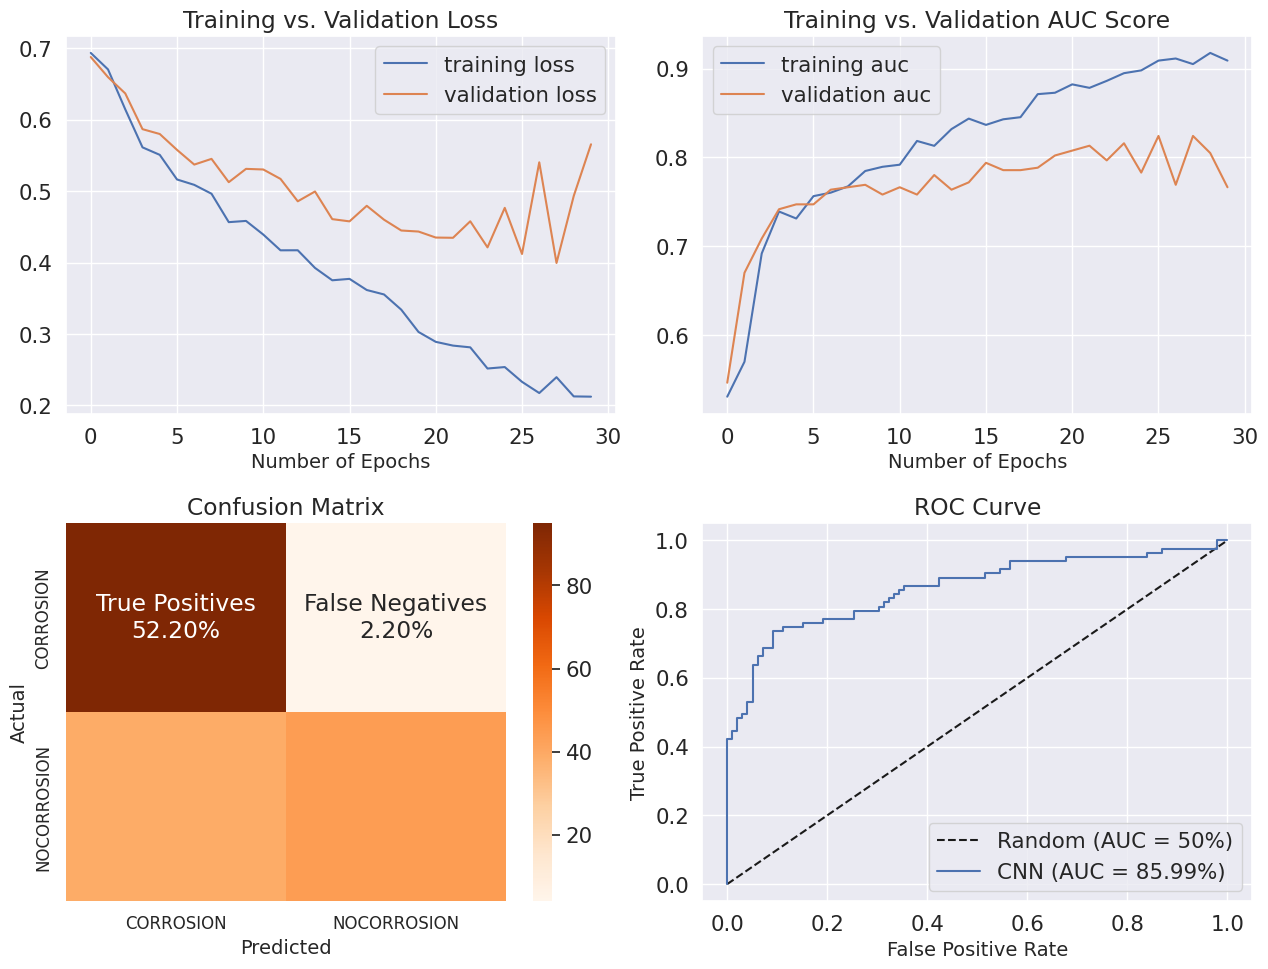

In [31]:
create_charts(model,cnn_model)
# model.save('/model/cnn3.h5')

In [32]:
model.save('cnn5.h5')

/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

# Set the path to your dataset
data_dir = './resize_data'


# Load pre-trained VGG16 model with ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Build a new model on top of VGG16
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 32768)             0         
                                                                 
 dense_8 (Dense)             (None, 128)               4194432   
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 18909249 (72.13 MB)
Trainable params: 4194561 (16.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [20]:
# Train the model

cnn_model = model.fit_generator(train_generator,
                              epochs = 30,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1)

/tmp/ipykernel_4715/119983786.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn_model = model.fit_generator(train_generator,


Epoch 1/30
40/40 [==============================] - 206s 5s/step - loss: 0.8919 - accuracy: 0.7141 - val_loss: 0.3932 - val_accuracy: 0.8159
Epoch 2/30
40/40 [==============================] - 207s 5s/step - loss: 0.3180 - accuracy: 0.8641 - val_loss: 0.3036 - val_accuracy: 0.8626
Epoch 3/30
40/40 [==============================] - 204s 5s/step - loss: 0.2239 - accuracy: 0.9128 - val_loss: 0.3310 - val_accuracy: 0.8681
Epoch 4/30
40/40 [==============================] - 203s 5s/step - loss: 0.1805 - accuracy: 0.9301 - val_loss: 0.2873 - val_accuracy: 0.8791
Epoch 5/30
40/40 [==============================] - 203s 5s/step - loss: 0.1575 - accuracy: 0.9364 - val_loss: 0.2744 - val_accuracy: 0.8846
Epoch 6/30
40/40 [==============================] - 202s 5s/step - loss: 0.1099 - accuracy: 0.9615 - val_loss: 0.2975 - val_accuracy: 0.8874
Epoch 7/30
40/40 [==============================] - 202s 5s/step - loss: 0.0885 - accuracy: 0.9701 - val_loss: 0.3109 - val_accuracy: 0.8846
Epoch 8/30
40

/tmp/ipykernel_4715/2805508428.py:21: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))


[Summary Statistics]
Accuracy = 87.36% | Precision = 83.33% | Recall = 95.96% | Specificity = 77.11% | F1 Score = 89.20%


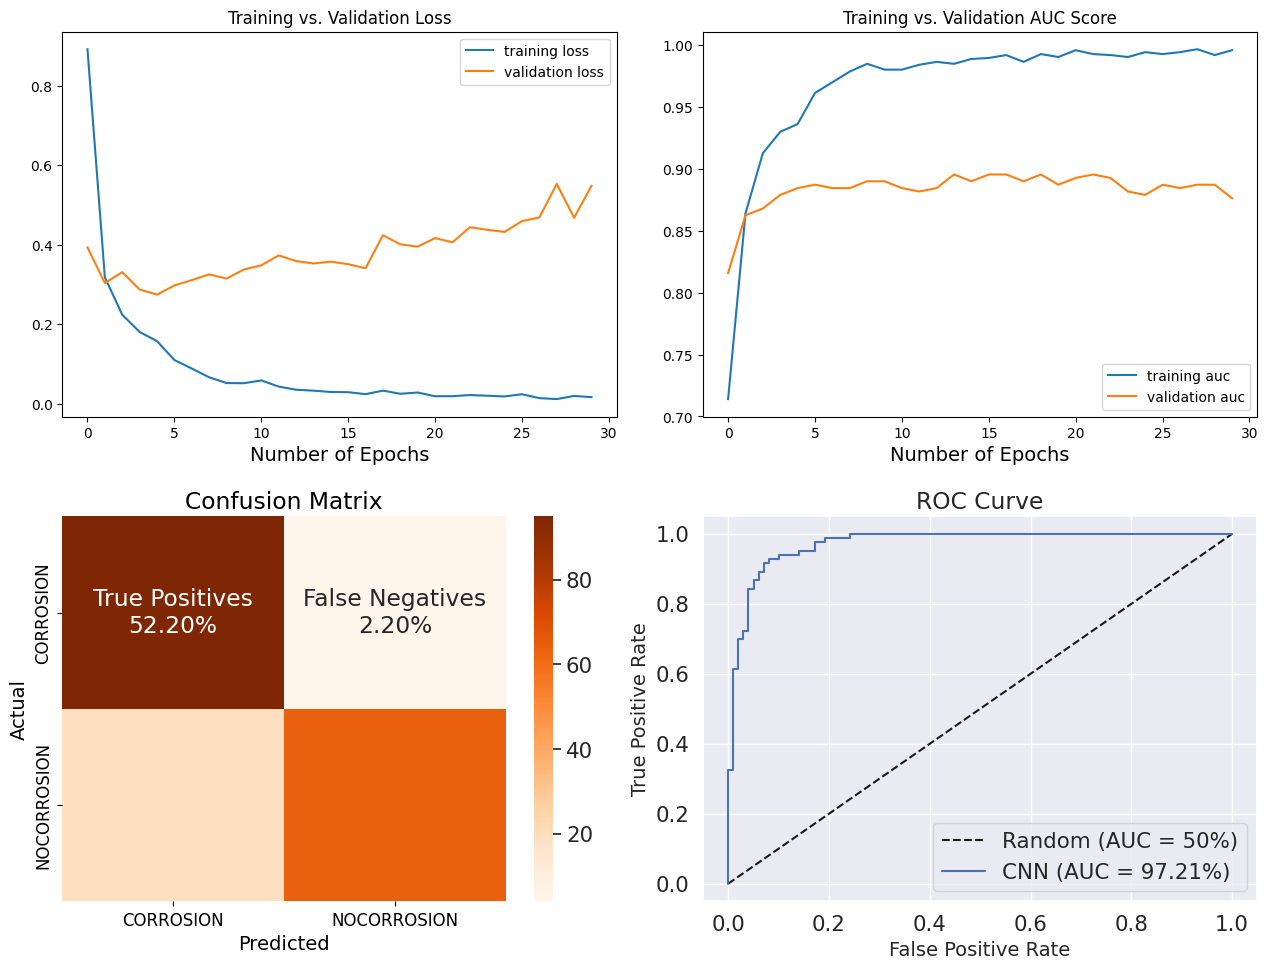

In [21]:
create_charts(model,cnn_model)


In [22]:
model.save('/model/pre-train.h5')

/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


PermissionDeniedError: /model; Permission denied